In [ ]:
# 107303538_0930_hw3_3

CycleGan

ResNet素材庫

In [ ]:
import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

網路設定 & 匯入轉圖片網路(pth)

In [ ]:
netG = ResNetGenerator() # netG網路
model_data = torch.load("horse2zebra_0.4.0.pth") # 載入路徑的東西
netG.load_state_dict(model_data) # load_state_dict用預先訓練的參數去跑網路
netG.eval() # 開啟訓練模式

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

圖片前處理

In [ ]:
from torchvision import transforms # 影像處理的
preprocess = transforms.Compose([transforms.Resize(256), # 大小變 256 * 256
                  transforms.ToTensor()]) # 照片轉成tensor

匯入圖片 & 處理訓練

In [ ]:
# 第一個img
from PIL import Image # 匯入外部圖片
img = Image.open("horse.jpg") # 匯入圖片
img_t = preprocess(img) # 前處理 
batch_t = torch.unsqueeze(img_t, 0) # 加橫軸(列)轉tensor
batch_out = netG(batch_t) # 訓練
out_t = (batch_out.data.squeeze() + 1.0) / 2.0 # 調整成灰階圖片(可略)
out_img = transforms.ToPILImage()(out_t) # tensor轉換成普通圖片 ToPILImage
out_img # 顯示圖片
img.save("out_img.jpg") # 儲存圖片

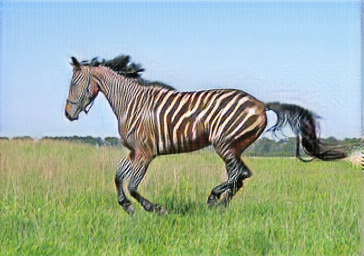

In [ ]:
# 第二個img1
img1 = Image.open("horse1.jpg")
img1_t = preprocess(img1) # 把圖片轉成tensor 讓電腦看得懂
batch1_t = torch.unsqueeze(img1_t, 0) # 把img_t放到第一軸
batch1_out = netG(batch1_t) # 把轉成tensor 放進去訓練
out1_t = (batch1_out.data.squeeze() + 1.0) / 2.0 # 調整成灰階圖片
out1_img = transforms.ToPILImage()(out1_t) 
out1_img
img.save("out1_img.jpg")

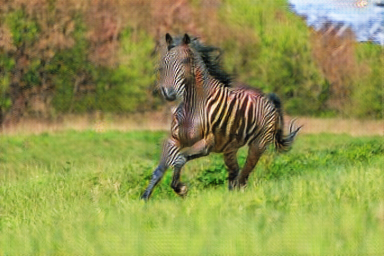

In [ ]:
# 第三個img2
img2 = Image.open("horse2.jpg")
img2_t = preprocess(img2) # 把圖片轉成tensor 讓電腦看得懂
batch2_t = torch.unsqueeze(img2_t, 0) # 把img_t放到第一軸
batch2_out = netG(batch2_t) # 把轉成tensor 放進去訓練
out2_t = (batch2_out.data.squeeze() + 1.0) / 2.0 # 調整成灰階圖片
out2_img = transforms.ToPILImage()(out2_t)
out2_img
img.save("out2_img.jpg")